In [1]:
import numpy as np
from matplotlib import pyplot as plt
import h5py

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import preprocess_input

from lime import lime_image

In [2]:
import h5py as hd
pannuke= hd.File('/mnt/nas2/results/IntermediateResults/Camelyon/pannuke/patches_fix.hdf5', 'r', libver='latest', swmr=True)
filename = "../input/pannukeall/all_tumor_pannuke.hdf5"
f = pannuke

f['pannuke/fold1/75/tumor'].keys()
im = f['pannuke/fold1/75/tumor/center/patch'][0]
mask = f['pannuke/fold1/75/tumor/center/mask'][0]

In [4]:
model = tf.keras.models.load_model('/mnt/nas2/results/IntermediateResults/Mara/MELBA/baseline_def_1/best_model.h5', compile=False)
model.layers[-1].activation = tf.keras.activations.sigmoid
model.compile()

In [6]:
#We don't directly use the base model because we want to be sure we are perturbing the images before preprocessing them.
#Otherwise covering the superpixels in 0 might not mean covering them in black.
#Best way to control this is to just define a wrapper-like class around the model, that includes the preprocessing in it.
#I'm also converting the sigmoid output to softmax-like because that's generally easier to handle and debug in LIME.
#GradCAM doesn't care about any of this so we can just use the model directly.

class MyModel():
    def __init__(self,model):
        self.model = model
        self.input_shape = model.input_shape
        self.output_shape = model.output_shape
        
    def predict(self, batch_images):
        
        #Image must be preprocessed before passed to LIME.
        batch_images = preprocess_input(batch_images.copy()) 
        
        sigm = self.model.predict(batch_images)
        
        softm = np.hstack((1-sigm,sigm))
        
        return softm


model_with_preprocessing = MyModel(model)

(-0.5, 223.5, 223.5, -0.5)

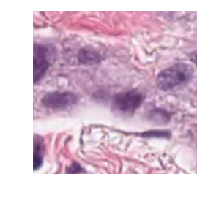

In [7]:
plt.rcParams['figure.figsize']=(3,3)
plt.imshow(np.asarray(im, dtype=np.uint8))
plt.axis("off")

In [10]:
#!pip install pandas
#!pip install seaborn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

In [13]:
from skimage.segmentation import mark_boundaries
heats = []
entries=[]
dict_heats={}
squares = np.zeros(im.shape[:2])
counter = 0
for hor in range(3):
    for ver in range(3):
        squares[75*hor:75*(hor+1),75*ver:75*(ver+1)]=counter
        counter+=1

#Renumber segments, because they are numbered arbitrarily in the mask files.
segments = np.sum(mask[:,:,0:5],axis=2).copy()

temp_renumber = [8+item for item in list(range(len(np.unique(segments))))]

renumbering_map = dict(zip(np.unique(segments),temp_renumber))

segments = np.vectorize(renumbering_map.get)(segments)
segments = np.where(segments.copy()==8,squares,segments)

#LIME is expecting a segmentation function, so we define one just to pass the segments above as superpixels.
def segfunc(im):
    return segments

#Mark the nuclei
mark_colors = [[1,0,0],[0,1,0],[0,0,1],[1,1,0],[1,0,1]]
mark = im.copy()/255

for i in range(5):
    mark = mark_boundaries(mark,mask[:,:,i].astype('uint8'),mode='outer',outline_color=mark_colors[i])

In [14]:
import skimage.segmentation

def segments_quickshift(im):
    
    return skimage.segmentation.quickshift(im, 
                                           kernel_size=4,
                                            max_dist=200, ratio=0.2)

In [9]:
#Normalize
areas = np.unique(segments,return_counts=True)
dict_areas = dict(zip(areas[0].astype('uint8'),areas[1]))
heatmap_areas = np.vectorize(dict_areas.get)(segments)
#heatmap_normalized = np.divide(heatmap,heatmap_areas)

#Renumber segments, because they are numbered arbitrarily in the mask files.
"""
segments = mask[:,:,0].copy()
for i, num in enumerate(np.unique(mask[:,:,0])):

    segments[segments==num]=i

#LIME is expecting a segmentation function, so we define one just to pass the segments above as superpixels.
def segfunc(im):
    return segments"""
rep = 10
for r in range(rep):
    np.random.seed(r)
    #Generate LIME explanation for class 1
    explainer = lime_image.LimeImageExplainer()
    class_idx=1
    explanation_genetic = explainer.explain_instance(im.copy(), 
                                                     model_with_preprocessing.predict, 
                                                     segmentation_fn = segfunc, 
                                                     top_labels=3,#Just making sure we generate explanations for both classes. Any number >2 should work. 
                                                     hide_color=0,#Cover superpixels in black. 
                                                     num_samples=200,
                                                     progress_bar=False, 
                                                    random_seed=r)
    dict_genetic = dict(explanation_genetic.local_exp[class_idx])
    heatmap = np.vectorize(dict_genetic.get)(explanation_genetic.segments)
    heats.append(heatmap)
    print(explanation_genetic.score)
    if r==0:
        for el in explanation_genetic.local_exp[class_idx]:
            dict_heats[el[0]]=[]
            dict_heats[el[0]].append(el[1])
    else:
        for el in explanation_genetic.local_exp[class_idx]:
            dict_heats[el[0]].append(el[1])

    for k in dict_heats.keys():
        for el in dict_heats[k]:
            entries.append((k,el))

KeyboardInterrupt: 

In [36]:
weights=pd.DataFrame(entries)
#weights = pd.DataFrame(dict_heats)

In [37]:
weights=weights.rename(columns={0:"dimensions", 1: "weight"})

In [38]:
def show_segment_contours(mark, segments,i):
    img=np.zeros(np.shape(mark))
    img[:,:,0]=(segments==i-1)*1 * mark[:,:,0]
    img[:,:,1]=(segments==i-1)*1 * mark[:,:,1]
    img[:,:,2]=(segments==i-1)*1 * mark[:,:,2]
    return np.asarray(img)

In [17]:
def segment_type(mask, segment):
    type_=None
    for i in range(6):
        if np.sum(segment*mask[:,:,i])>0:
            return i
    return None

In [18]:
heats = []
entries=[]
segments_list=[]
img_idx=0
for fold in [1,2]:
    for el in f['pannuke/fold{}'.format(fold)].keys():
        print(el)
        if 'tumor' in f['pannuke/fold{}/{}/'.format(fold,el)].keys():
            im=f['pannuke/fold{}/{}/tumor/center/patch'.format(fold,el)][0]
            mask=f['pannuke/fold{}/{}/tumor/center/mask'.format(fold,el)][0]

            #Generate Squares
            from skimage.segmentation import mark_boundaries
            squares = np.zeros(im.shape[:2])
            counter = 0
            for hor in range(3):
                for ver in range(3):
                    squares[75*hor:75*(hor+1),75*ver:75*(ver+1)]=counter
                    counter+=1

            #Renumber segments, because they are numbered arbitrarily in the mask files.
            segments = np.sum(mask[:,:,0:5],axis=2).copy()

            temp_renumber = [8+item for item in list(range(len(np.unique(segments))))]

            renumbering_map = dict(zip(np.unique(segments),temp_renumber))

            segments = np.vectorize(renumbering_map.get)(segments)
            segments = np.where(segments.copy()==8,squares,segments)

            #LIME is expecting a segmentation function, so we define one just to pass the segments above as superpixels.
            def segfunc(im):
                return segments

            #Mark the nuclei
            mark_colors = [[1,0,0],[0,1,0],[0,0,1],[1,1,0],[1,0,1]]
            mark = im.copy()/255

            for i in range(5):
                mark = mark_boundaries(mark,mask[:,:,i].astype('uint8'),mode='outer',outline_color=mark_colors[i])

            #Normalize
            areas = np.unique(segments,return_counts=True)
            dict_areas = dict(zip(areas[0].astype('uint8'),areas[1]))
            heatmap_areas = np.vectorize(dict_areas.get)(segments)
            heatmap_normalized = np.divide(heatmap,heatmap_areas)

            #Renumber segments, because they are numbered arbitrarily in the mask files.
            """
            segments = mask[:,:,0].copy()
            for i, num in enumerate(np.unique(mask[:,:,0])):

                segments[segments==num]=i

            #LIME is expecting a segmentation function, so we define one just to pass the segments above as superpixels.
            def segfunc(im):
                return segments"""
            rep = 10
            for r in range(rep):
                #Generate LIME explanation for class 1
                np.random.seed(r)
                explainer = lime_image.LimeImageExplainer()
                class_idx=1
                explanation_genetic = explainer.explain_instance(im.copy(), 
                                                                 model_with_preprocessing.predict, 
                                                                 segmentation_fn = segfunc, 
                                                                 top_labels=3,#Just making sure we generate explanations for both classes. Any number >2 should work. 
                                                                 hide_color=0,#Cover superpixels in black. 
                                                                 num_samples=200,
                                                                 progress_bar=False, 
                                                                random_seed=r)
                dict_genetic = dict(explanation_genetic.local_exp[class_idx])
                heatmap = np.vectorize(dict_genetic.get)(explanation_genetic.segments)
                heats.append(heatmap)
                print(explanation_genetic.score)

                for el in explanation_genetic.local_exp[class_idx]:
                    try:
                        dict_heats[el[0]].append(el[1])
                        seg=(explanation_genetic.segments==el[0])*1
                        st=segment_type(mask, seg)
                        segments_list.append((st,seg))
                        entries.append((img_idx,st,el[1]))
                    except:
                        dict_heats[el[0]]=[]
                        dict_heats[el[0]].append(el[1])
                        seg=(explanation_genetic.segments==el[0])*1
                        st=segment_type(mask, seg)
                        segments_list.append((st,seg))
                        entries.append((img_idx,st,el[1]))
        img_idx+=1
            #for k in dict_heats.keys():
            #    for el in dict_heats[k]:
            #        entries.append((k,st,el))
                    

0
0.447336278843662
0.4894028602525907
0.4658374523303647
0.5104112224134401
0.42701588933728973
0.40143284149419434
0.4490616367007988
0.47100418388896403
0.4017959509255763
0.4769911889226951
1
0.33217901549060325
0.4871516655520206
0.23892355234533147
0.3342491541748396
0.35933226575442884
0.25881173836161253
0.32962397822798273
0.33084460119667203
0.31077299933349034
0.3698282961261897
10
0.3673540877871777
0.41726556882669386
0.4244420694049573
0.41225687121396903
0.33362137530608604
0.3544516827169727
0.3687743389223892
0.3698570745180666
0.484930554355415
0.41652476531720206
100
0.4555044802556565
0.47933251768235463
0.5252365303578168
0.5113604399019476
0.5223740280464542
0.538532233270702
0.397806710665349
0.477356079293767
0.4720808825409046
0.5364658785353004
101
0.45971534054156993
0.41705472054463855
0.4124528890851026
0.33793973818107303
0.32438507960768936
0.2825775115708016
0.29973644668346366
0.33734279066632555
0.3527249220429809
0.35819257271974503
102
0.342471334857

0.4841189723887193
0.5212439462876503
0.42649909962452937
0.4448680530891009
0.5304318533749907
0.4558884141987998
0.5010862437685406
17
0.6667780810217603
0.590922880340389
0.5946215324353079
0.64857528690513
0.5881554356881522
0.5325155366454528
0.5746571397843083
0.6569064292171432
0.6245705778032491
0.6431793835649051
170
1700
0.3059135911681312
0.4001082502920315
0.46861672127386644
0.4529277304662376
0.4860971973663606
0.4719067998048678
0.39039120057218024
0.5251551036014823
0.4853714272687624
0.49269368142392994
0.4707167647177055
1742
0.4121329765821371
0.47641872243747097
0.45864497123316883
0.3737472464157746
0.4841715165889188
0.5712380848695477
0.39499389621159975
0.4442640109041317
0.46900532140439444
1743
0.4902524709345665
0.5245092708229784
0.5237345853512471
0.5363460769503898
0.6708055194570117
0.5000586997615193
0.48097278127393533
0.5556671592612676
0.5374432721098412
0.47231014980220876
1744
0.4837382205220577
0.5251089127929212
0.46162344706121194
0.3093844688598

0.40884348060359343
0.45820719936173404
0.41440392095319023
0.49536890101535747
0.40660346057498764
0.3934869809591255
286
0.5419132278438978
0.566414537107158
0.4491108183307795
0.5622533184043328
0.3972421117011947
0.5656584653350434
0.45296587607305083
0.4332540757533355
0.505604809211612
0.41783785518621275
287
0.30734555276075126
0.40938243787988604
0.3938886849617644
0.40725702277391496
0.42416858536546287
0.3756359578608989
0.43434019929453094
0.37828257019826506
0.4105341408748488
0.3687143140527893
288
289
29
0.40467657435632687
0.4228401596569248
0.43174851211068754
0.40613098755714516
0.30596966331437303
0.3714427335149546
0.425899996556789
0.37641488480139307
0.4177187087658898
0.38763356836770024
290
0.5954001922586387
0.683478020330238
0.6185825198009597
0.6986467296369655
0.6495784928204984
0.656319167677742
0.6447963794462386
0.6332632177868385
0.6115485688630387
0.6701125466772958
291
292
0.40178763437933485
0.29286438708702667
0.3518447338726931
0.31127116870145155
0.

0.41988765502213377
0.30645759487948854
0.4992247935038886
348
0.4228635013292654
0.45914541504250683
0.4391632350667306
0.4372929530459985
0.45642377045931576
0.4681260226696133
0.43016328035211815
0.3944395835482648
0.41471764106496956
0.47089071842261476
349
0.6153922161746079
0.5374295594062224
0.6080423831802901
0.6132123487355695
0.5866043334179892
0.604322605779415
0.5502702156286692
0.6572971936027422
0.5940982491240131
0.5796756780789423
35
0.5046144016412824
0.4535131976971678
0.4696253843540832
0.37413798330887627
0.4087762331583851
0.48370202317802974
0.46778025089513753
0.4281875006525455
0.3912365159741782
0.49213967988128327
350
0.42596061114656436
0.44200359494082614
0.5229681771284944
0.4463862261435547
0.39451067349764546
0.4265468242973015
0.47880397028887295
0.3911062991605765
0.45852006973141946
0.39314217749052593
351
0.6548175977989761
0.45359844646148995
0.5840475440415722
0.5132829131182459
0.5712914160933316
0.5809905419907095
0.44088527460237437
0.50286052304

0.5386549272126848
0.6021720660242218
0.5558895602321317
0.45771887222145025
0.4602201946935568
0.5828851637234875
0.5358542136073843
387
0.4890093643308924
0.4889362916980995
0.2885531649359965
0.3695327264743403
0.5031365069626319
0.4028659745226275
0.4089600473166217
0.31982337447033
0.4162148434387386
0.3707457136593242
388
0.4127777311276809
0.45436591709891605
0.3462625633766845
0.3981888861362233
0.40504976804588
0.3960121973893206
0.4313094927938612
0.4924330522229588
0.4002835668004473
0.35994089165868337
389
0.4494548484647949
0.5012382687634128
0.48270781755441383
0.5219790484909392
0.48682778059495646
0.4396634246029173
0.4880090123130055
0.3876997781319239
0.4424597196377029
0.5502187237437898
39
0.23204021887887494
0.2562127439175891
0.3070774867249073
0.33539464357563553
0.2637187988883365
0.31248165258679395
0.197289256410324
0.2054472696966333
0.24265595893008218
0.25213940110380006
390
0.4689869451544558
0.445590932898949
0.398018377714884
0.3133021424228982
0.3555919

0.48840072759597364
43
0.4346179641208725
0.417820991219083
0.37562367119439033
0.3489701106595761
0.3128702758379104
0.41056212461544406
0.34863223238489194
0.4161346437762748
0.33926732007255256
0.40081841935479634
430
0.4895296277873434
0.49216235581888235
0.49111377056404676
0.4752500312304093
0.5323138689760157
0.4474600656205648
0.5072268125875676
0.4209254037674258
0.48510115092372363
0.47328018713922115
431
0.4783818200398675
0.44185041411398085
0.47324603080475636
0.46892351992869075
0.5062967046816939
0.4900583073600864
0.44818211673809183
0.40736750695526547
0.3523510821398498
0.4310611771925049
432
0.5482131997558406
0.5761976810049736
0.5460243986504754
0.46734757897228896
0.46834561717661205
0.4642310123302303
0.5014097386624421
0.44026881611534885
0.39126762117574976
0.43208640039684176
433
0.36667263945307516
0.34928299427244003
0.4000366046049042
0.40878858852775135
0.33949110034596863
0.42098170332528656
0.36610581225234007
0.3764260165680354
0.40167156406531845
0.284

0.4206596220285741
0.4555785104249427
0.39521079610224047
0.4674264897676552
0.5419536487833669
0.5039539044671906
0.49543785029472787
478
0.26581311581450207
0.32376418384437594
0.2962310171827566
0.21272825889519342
0.2910110926433275
0.37044916769546277
0.37603251442747687
0.2990209992278877
0.30453311637025554
0.3857426494746862
479
0.4629367273660033
0.6176382691242579
0.5014562062402677
0.6098310105462235
0.5348205410681437
0.5282791078826119
0.5645910826618141
0.579259915085508
0.5430772555906054
0.5052013391386772
48
480
0.565469282772848
0.4635138727362483
0.6082444938383145
0.4156330223348911
0.4662232032092499
0.5589905505437183
0.5498972958694559
0.42449080357552793
0.5540640695978309
0.49135509567082114
481
0.31038630963642455
0.4211476706041306
0.45944245530728567
0.4278316687219449
0.45872461235343664
0.42339147110547576
0.44243117823491607
0.33380641383696175
0.4118644631918631
0.4823271261883345
482
483
0.3540093048580474
0.3106912309270129
0.30725944163913954
0.364003

0.4636080804651577
52
0.43985005098717445
0.5078418672155001
0.5013150181601462
0.4935774495183477
0.5049447847057469
0.5209213372237598
0.46488115766640625
0.5016505979942858
0.612344768546895
0.4960759861528501
520
0.3792029423537272
0.32923871875973654
0.36679033841639375
0.32741083371237223
0.38975516757896844
0.3492931216093299
0.3482076692233632
0.4099354622860122
0.3575242458328173
0.35754590806741593
521
0.4556346058529245
0.4483606059264731
0.44482853556231805
0.37747270735796157
0.4433403132906107
0.4315837585238446
0.502141776832984
0.44988051872326634
0.46673407256022165
0.4073326428497531
522
0.5576317309095408
0.616032763475362
0.518493562093453
0.5767354589154798
0.5611861741510447
0.42080173994538095
0.5076997435943247
0.5926241887906353
0.4989760633279954
0.5529586472258454
523
0.4389888928005415
0.3616421059116952
0.41579671709222243
0.42526084674934406
0.41491169649943715
0.4403157662650162
0.4235763170433201
0.4605460506490409
0.4361637814837067
0.47607092254846134


0.5465537672859844
0.5566770483523245
0.5316588998597293
0.5006602736305008
0.4878362711789628
561
0.431790793259595
0.4651506827321503
0.503468078650176
0.5170004945053341
0.5244651301755546
0.47515209726110186
0.463589056688143
0.4279231311521694
0.538563359108573
0.4889534060301475
562
0.43276933581430005
0.4905860010164221
0.46026766934429053
0.5071000147154183
0.5529745550514431
0.465923993796707
0.5536794243054061
0.43359189368080003
0.4633143502242788
0.49957362824472473
563
0.4251496494823399
0.4104104621339689
0.4437994591982337
0.4635255914195805
0.5196314423642564
0.502502474516939
0.5509535441961964
0.4443813493955383
0.40113265910938234
0.5189645053838127
564
0.247102801102035
0.21621526583318673
0.34564893500780214
0.23221079037686668
0.38616254576312425
0.3428791837038183
0.2743860218260932
0.31592077049667866
0.27934908283538185
0.25134048518799057
565
566
567
568
569
57
570
571
572
573
574
575
0.470632205191827
0.4729408514396771
0.4456708730568194
0.41264251166622856


0.46949889521591803
616
0.4197860258747844
0.3674739090375282
0.3812486388551698
0.39600524433500073
0.44407512592428755
0.38775627471656493
0.38514375696909653
0.3959424504674772
0.2991642738158464
0.3958478103208979
617
0.27318323942577505
0.23361106898116235
0.29345942016149884
0.28497641072372903
0.3202810494907752
0.3291212845083551
0.3674731235957748
0.42157852380008365
0.30815893266201366
0.36473202594652643
618
0.3880384246218485
0.38336932450112343
0.4775762310724247
0.42857289923410957
0.34918847769297395
0.4386098083009066
0.48008199565549214
0.45624738232885287
0.44056674887849323
0.4691075893974094
619
0.40140244704172223
0.4023516442137238
0.564313993222368
0.5201120814155493
0.5394762486291036
0.4047299811624787
0.5369146615731349
0.47655665340818903
0.40272211263265156
0.48278886049073505
62
620
621
622
623
624
625
626
627
0.22034136561331064
0.3494556311342261
0.3430993847995986
0.34866366314386904
0.43434728813446233
0.36522073801461163
0.4369981754468125
0.2336909809

0.6110161175043289
0.6225676783609592
0.571573366398057
684
685
686
0.41137209141519027
0.4566334667515515
0.4884866356615089
0.45113132350518237
0.33547744365622467
0.31533170492416207
0.4245042093103676
0.383328801775779
0.44345591802687023
0.3342003131721193
687
0.6241984081692764
0.5251047784519638
0.5593191080450769
0.5974109997256799
0.5264250851231895
0.5055412261573422
0.4329411667363403
0.46503244707387476
0.5212155023177987
0.5213989615868022
688
0.455036451261718
0.5177682367323517
0.4728798569413916
0.4792555179153901
0.5205303110440789
0.34309218422163434
0.4833241871228561
0.49471535055206095
0.5004151526806564
0.5315365851029188
689
0.41236297452325205
0.449470398084877
0.38835055609033287
0.35148826065942596
0.45071226965851163
0.4230864473278069
0.4425699694807412
0.3408584833579126
0.4118377101916354
0.4404287806459017
69
690
691
0.4644165122945801
0.49546228566557393
0.4748238762809427
0.36084484004113043
0.4327120289398846
0.41125826902055246
0.43452171055490585
0.3

0.4648592147328261
0.49250563701081507
0.3725830816776483
0.3572866108811409
731
0.4996602845676547
0.5863294129198682
0.582242311112044
0.5353791291814136
0.6566816232690185
0.5706276889018851
0.5439815970807778
0.4924263982153407
0.58113408536783
0.6304407062267168
732
0.4486086812897879
0.5103807280052515
0.4015631436882403
0.3757268297104914
0.40378718791168466
0.4325919340746641
0.4692868616908108
0.43619390720385376
0.3899910203455462
0.46208328444659097
733
0.4830014786417002
0.495576128723403
0.47881887815231994
0.463678772928675
0.4935816078152984
0.4975277053661298
0.5358829603114543
0.43151825688402806
0.46423445787976547
0.4636317764983313
734
0.3212975345020066
0.382618621504639
0.3304591433099324
0.46049653745444846
0.45933225174703696
0.3139146259086214
0.39682645610999523
0.39520317184270476
0.399835931821943
0.32901143665663646
735
0.46998257196646454
0.5039258134555615
0.49202565231985074
0.4445182052709383
0.3965804299006193
0.4953981464627561
0.4680575895733732
0.43

0.5900341713537924
0.6075583441752201
0.6272020489850809
0.5707363938642382
0.5996516047438611
0.5495486399168779
0.5745780617635156
0.6052418081196378
100
101
0.5178877065467563
0.4402956726230389
0.3590715090328863
0.37975530761996235
0.395406918826819
0.4133739499111191
0.4831329156893769
0.41195537828099216
0.39402919601558817
0.4920061545496248
102
0.5582914518812114
0.5569152797761114
0.523055852791878
0.5212432305840689
0.4672014351975827
0.5293538006745622
0.5132006929588723
0.5833085093366968
0.5675591903178154
0.47639613375750306
103
104
105
0.5273734424141123
0.5095774067609542
0.49428701198542924
0.5389858021439726
0.5224206118548522
0.6324934539164662
0.401221303966771
0.4870287803232037
0.5174149402165882
0.5055360180198667
106
0.34759912739996934
0.4399283489976071
0.39643040942809993
0.4612421340587822
0.4558345655488547
0.4262513078119049
0.46344787871919324
0.3535287140593879
0.4699261054642111
0.45160778320903566
107
0.6263009406671748
0.5753752370642946
0.5814867546

0.4338394685233557
0.5509640280722443
0.517422649797131
0.5367416216089809
0.5088155664141996
0.49025586407042054
0.5570928146960619
0.5817051699374772
0.49071653728550724
0.4705670565995411
153
1530
0.45758043528823844
0.4232262047107619
0.3729521753943241
0.34190427108983457
0.5036786167331861
0.32413846983727324
0.3560873822000882
0.4311961847415233
0.4808638177145583
0.4468643496804472
1531
0.5484379932844807
0.5519065645133175
0.48671989261397497
0.5509363497131439
0.4975963456038922
0.4911320435267008
0.6193248573562719
0.4868365466426158
0.5006021738488224
0.5603889686244987
1532
1533
1534
1535
1536
1537
1538
1539
154
1540
1541
1542
1543
1544
1545
1546
1547
0.6673639009655219
0.5977347763984973
0.5882291207856583
0.5951464359051263
0.5443764014346053
0.671139547141693
0.6366593478284568
0.6538825133923847
0.7057934539601409
0.5715998830611805
1548
0.5786766043147057
0.6317944169375167
0.6723054638792629
0.6210373565601264
0.7083783541587377
0.6654522207643527
0.6699463925622153


0.4756006848974613
279
0.30808416241302117
0.41680378200557133
0.4298770465333809
0.29189768895607066
0.28981495260610224
0.407068820679864
0.34034791905124706
0.2743326305658689
0.3738010497266834
0.355366650876669
28
0.5610242073839263
0.5269717968105367
0.47042951495492946
0.5858338607598867
0.5755801275019994
0.6616581900594263
0.48892413537291746
0.5714145244449093
0.5627274590973401
0.5614359754071443
280
0.4128430664624877
0.51375195547294
0.40580247340402176
0.37791185720120424
0.4849421373523176
0.4561655409973584
0.49342466923765593
0.4179232009897906
0.34303150717890546
0.3853735128677371
281
282
283
284
0.48011129334809755
0.5358960754622528
0.465965217865555
0.4926112693623558
0.5428847797752147
0.4642718322600601
0.4261562816580188
0.48539879191920204
0.47750600233054863
0.4503210480484571
285
0.33707659067803486
0.36476728271426395
0.43814997112943765
0.3162156386083419
0.3918872378572005
0.3297473215546526
0.31007156360520693
0.33715595489386174
0.3322918844834084
0.392

0.5441633074096128
0.4056347996142735
0.4074566758741327
0.408552261842853
0.4101164297687685
0.3909450510256257
0.5180232989407672
335
0.3644354674328878
0.37825553560165426
0.433388121466326
0.48221446395578016
0.4420293498399837
0.38072046151164307
0.34457688506874795
0.33276360406847094
0.3979499546917449
0.4197578938125166
336
0.6290403993221378
0.5561436883631771
0.5950132954798686
0.567137563955258
0.5516523677514787
0.5249518068161632
0.5650173487033541
0.5312950624434086
0.543836531111564
0.5298965807475713
337
0.42029594345734117
0.4772403450764903
0.4394563184757946
0.4724858513004962
0.5148876729762986
0.47064494990101396
0.5216498356716894
0.46265126219634684
0.5018015444144488
0.5183973849512469
338
0.524219576474468
0.4991062205480762
0.44249076774831975
0.47508303345993236
0.5076856574552218
0.4497805353782023
0.5539320573694313
0.5522695948447118
0.5083493521651463
0.5112880454185883
339
34
340
0.4730989528519469
0.619952465703547
0.4984676059444759
0.4021934013647097


0.35551845995665743
0.5458549179233205
0.38185672669328274
0.40810028150194355
0.37312528709226767
0.39772018353135563
0.4568840484721257
0.4326903381329611
0.40064453890461355
0.4876023510847431
379
0.4525700234649375
0.4434521981916983
0.5104210068536722
0.4667042525421671
0.5045967899406576
0.4848336965420294
0.5401518121006187
0.45709251491981795
0.45144049481451815
0.5884920822937609
38
380
0.40041395874868646
0.42191563885932326
0.4478301164410238
0.42754020318814645
0.37828693347021547
0.4328031358545663
0.37721923098484555
0.3533922698078289
0.44601039845005125
0.36745310654196506
381
0.3920588508479882
0.3658271692972789
0.528012950742702
0.4384452612578062
0.38462290125816234
0.43981143128474953
0.35721088595954353
0.4439119496409738
0.4830544415319713
0.42312728976871183
382
383
384
385
0.6035186565992458
0.5506988047458875
0.5217291813193652
0.5320031138438315
0.5628141847975408
0.5551144989003158
0.5137393279559428
0.5482529031558079
0.5306047633441218
0.5009583319210963
3

0.40979548049275283
0.41601033995472914
0.5423430013598902
0.5037777048278236
0.4991517316171925
0.38365720418265103
426
0.39825262851345367
0.3970894108162766
0.3010930462723609
0.44237017014401997
0.3276614497525686
0.29261155983334497
0.36578367313187865
0.30071705268672855
0.45489517543819713
0.2625210263583333
427
0.23540862298810938
0.3485048903132707
0.3299555518876657
0.37897902520370164
0.24199668478672898
0.33888098458937466
0.4465298204723966
0.4039095430568896
0.3781745358602673
0.36525540726906136
428
0.4895191797200033
0.47999344952232614
0.4741474093649134
0.381918447574524
0.4970208872015039
0.43389970443712467
0.4349097855662366
0.39447693581598453
0.5286659611279019
0.5077445760315202
429
0.5435762579243191
0.5973987114708386
0.47515570326669265
0.41787306376604083
0.5320600636693615
0.507974962395483
0.5704331299707919
0.39602162409247765
0.6028563046566002
0.5540374819233811
43
430
0.3983323569458762
0.5170258210023148
0.488284490529245
0.38824492315523085
0.4678946

0.4701049194403267
0.43245134855141204
0.48784933499625527
474
0.51849721353366
0.6168370239550659
0.6842667474638224
0.6212225288493824
0.5581550976539622
0.6350374463594476
0.6627162426329462
0.6245640529165881
0.604250056117938
0.6706794471923452
475
0.5242921096935224
0.5295545097773469
0.561294092673472
0.5361908685416494
0.5396505960013549
0.4971196253938766
0.5921762288693164
0.5361653670312891
0.6010547654315652
0.47099024732575234
476
0.46729568991476067
0.4976463518950944
0.4866712089082216
0.5063727908896594
0.5175668870146014
0.5148066568500618
0.5643136053056628
0.5041985685409178
0.625543927091044
0.4473333839172464
477
0.28634044222664146
0.359247234855269
0.39534070351315265
0.41430406493958893
0.37353623996880225
0.32942191591319825
0.35645472515670507
0.4292082097087665
0.3659038208298171
0.3685036800189354
478
0.3605822544636259
0.26389457803631045
0.2667517312839336
0.21885562575687575
0.3110093688269406
0.26150291004275483
0.33600052195423746
0.30816670687148684
0.

0.22364983001028094
0.3267133561747678
0.3534110823847807
0.1796631655968829
0.2830894139901933
0.3434452597765802
0.3909023033306943
521
522
523
524
525
526
527
528
529
53
530
531
532
533
0.40879666876693344
0.4428033439460766
0.4986907333248468
0.4233034460469164
0.43953695208543603
0.3637849830360329
0.49569797584261405
0.47876150473879636
0.5047010211420468
0.43467158133273925
534
0.48322028118336546
0.4660584102560651
0.4644758020732008
0.4285034276934835
0.5383010586687542
0.4029184759754031
0.4054717117942518
0.5266145861230395
0.516993688797611
0.4713226758432104
535
0.43880910189705735
0.31628435362533225
0.37548749416421856
0.4049309240561371
0.4983190745021449
0.4357452925637555
0.38725349697662426
0.3304309461448868
0.46880632686545204
0.3996298713629943
536
0.509052926142954
0.5763538311438022
0.47225632867233464
0.4409995603253253
0.5173284090055771
0.37043651477832673
0.47407768739036804
0.45669030938078514
0.5204223078508832
0.4476670401259484
537
0.42682646599063834
0.

0.4045354415426725
0.4289634100123089
0.40179548011604527
0.4331562228862637
0.5270661210945249
0.4618970979471244
0.46216822573513283
589
59
590
591
592
0.25705118627576695
0.3630589453177735
0.4135090421644497
0.37856307189659166
0.2722689986038588
0.4307887111775423
0.34017180739191966
0.39084239540471166
0.3278192310258894
0.3039752596423747
593
594
0.49256536472175033
0.4664263213622146
0.4210171270136042
0.3763403852846483
0.4254889790920622
0.42142868657734306
0.4992790161143564
0.4991712606428851
0.381868400803852
0.4593890703020447
595
596
597
598
0.31096051395400437
0.2718638084629005
0.32703909264401976
0.24880962767524506
0.2238483719678207
0.21914890764339068
0.2875627175665404
0.25079241389364126
0.31209100117771393
0.2768818562723968
599
0.3410338737556121
0.3382950503000808
0.20213815330792062
0.3064415872116446
0.2986057446785846
0.20826002815982392
0.2640903852340336
0.2526295831241776
0.27849904970668593
0.30568072186257855
6
0.41358225468617893
0.3892945959310149
0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [19]:
np.save('nentries.npy', entries)
np.save('nsegments_list.npy',segments_list)
np.save('ndict_heats.npy',dict_heats)

In [ ]:
# FROM HERE

In [44]:
entries

[(0, 0, 0.164311569985593),
 (0, 5, 0.11687372051688576),
 (0, 2, 0.10030813801587866),
 (0, 5, 0.08276816860021999),
 (0, 5, 0.051580207785216874),
 (0, 0, 0.04889095819906721),
 (0, 5, -0.046099465387428325),
 (0, 5, 0.04000397911257465),
 (0, 2, 0.02611337159735518),
 (0, 5, -0.021811310626854066),
 (0, 5, -0.01049438576516444),
 (0, 1, 0.007859289953974134),
 (0, 1, -0.007803511588804745),
 (0, 5, -0.006200651367408762),
 (0, 0, 0.005409900206785944),
 (0, 5, -0.0017478765121767927),
 (0, 0, 0.00011734063204865683),
 (0, 0, 0.15772643874864217),
 (0, 2, 0.10906106288767473),
 (0, 5, -0.08683251783841506),
 (0, 5, -0.0856174227987584),
 (0, 5, -0.08123589817208357),
 (0, 5, 0.06753435867329428),
 (0, 1, 0.04413176267458501),
 (0, 2, 0.04408192976348391),
 (0, 0, 0.03987809982962019),
 (0, 0, 0.03686590672405293),
 (0, 0, 0.03647794078514436),
 (0, 5, -0.036049702833598866),
 (0, 5, 0.026223214411821898),
 (0, 5, -0.017654999544267216),
 (0, 5, 0.017362676593011956),
 (0, 5, -0.01171

In [ ]:
#now you need to visualize stuff with the scatterplot
entries=np.load('nentries.npy')
segments_list=np.load('nsegments_list.npy', allow_pickle=True)
dict_heats=np.load('ndict_heats.npy', allow_pickle=True)

In [21]:
data = pd.DataFrame(entries)

In [22]:
data=data.rename(columns={0: "image", 1: "seg_type", 2:"weights"})

In [ ]:
entries=np.load('nentries.npy')

In [ ]:
entries.shape

In [23]:
new_column=[]
idx=0
means=[0,0,0,0,0,0]
stds=[0,0,0,0,0,0]
norm=[0,0,0,0,0,0]
for i in range(entries[-1][0]):
    seg_values={0:[], 1:[], 2:[], 3:[], 4:[], 5:[]}
    starting_idx=idx
    while(entries[idx][0]==i):
        seg_values[entries[idx][1]].append(entries[idx][2])
        idx+=1
    print(seg_values)
    for k in seg_values.keys():
        means[k]=np.mean(seg_values[k])
        stds[k]=np.std(seg_values[k])
        norm[k]=means[k]/stds[k]
    for i in range(idx-starting_idx):
        id_,type_,weight=entries[starting_idx+i][0],entries[starting_idx+i][1],entries[starting_idx+i][2]
        new_column.append((id_, type_, weight, means[type_],stds[type_], norm[type_]))
    #break

{0: [0.164311569985593, 0.04889095819906721, 0.005409900206785944, 0.00011734063204865683, 0.15772643874864217, 0.03987809982962019, 0.03686590672405293, 0.03647794078514436, 0.14651958291517425, 0.05956128958060689, 0.018268647297448117, 0.01688281488925409, 0.15308021432781616, -0.029025743605296635, 0.028749837168547135, -0.01946199849159095, 0.16514718326077152, 0.0856087719245726, 0.01759616796595245, -0.009345408010408288, 0.16884764956661558, -0.030232238918411328, 0.027790427195013512, 0.022467464254506183, 0.17537941998460768, 0.05268748664273652, 0.03794309629406906, -0.0013980113638325782, 0.1576305411369464, 0.0592699915336719, -0.00989819381306502, -0.007334876040226178, 0.1682590522028271, 0.04346755843999336, 0.041097043286513035, 0.007695426478309496, 0.16955137438958237, 0.06992980646983031, 0.023728393335876515, 0.013837114773790663], 1: [0.007859289953974134, -0.007803511588804745, 0.04413176267458501, 0.0025372083587004153, 0.03929750002965819, 0.02821784918990223, 

/home/mara/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mara/venv/lib/python3.5/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mara/venv/lib/python3.5/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/mara/venv/lib/python3.5/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/mara/venv/lib/python3.5/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopu

In [ ]:
new_column

In [24]:
data_new=pd.DataFrame(new_column)
data_new=data_new.rename(columns={0:"id", 1:"type",2:"weights",3:"avg", 4:"std", 5:"normalized"})

In [ ]:
from icc import *

In [ ]:
ICC_rep_anova(data_new[['avg', 'std']])

In [45]:
np.save("def-entries.npy", entries)

In [16]:
import scipy.stats
import skimage.segmentation
from skimage.segmentation import mark_boundaries
heats = []
entries=[]
dict_heats={}
squares = np.zeros(im.shape[:2])
counter = 0
for hor in range(3):
    for ver in range(3):
        squares[75*hor:75*(hor+1),75*ver:75*(ver+1)]=counter
        counter+=1

#Renumber segments, because they are numbered arbitrarily in the mask files.
segments = np.sum(mask[:,:,0:5],axis=2).copy()

temp_renumber = [8+item for item in list(range(len(np.unique(segments))))]

renumbering_map = dict(zip(np.unique(segments),temp_renumber))

segments = np.vectorize(renumbering_map.get)(segments)
segments = np.where(segments.copy()==8,squares,segments)

#LIME is expecting a segmentation function, so we define one just to pass the segments above as superpixels.
def segfunc(im):
    return segments

#Mark the nuclei
mark_colors = [[1,0,0],[0,1,0],[0,0,1],[1,1,0],[1,0,1]]
mark = im.copy()/255

for i in range(5):
    mark = mark_boundaries(mark,mask[:,:,i].astype('uint8'),mode='outer',outline_color=mark_colors[i])
def segments_quickshift(im):
    return skimage.segmentation.quickshift(im, 
                                           kernel_size=4,
                                            max_dist=200, ratio=0.2)

In [19]:
import sklearn.metrics

In [ ]:
#heats = []
#entries=[]
#segments_list=[]
#spearmans_r={}
#lime_list_sr=[]
lime_list_sr=open('limelistsr.txt', 'a')
sharplime_list_sr=open('sharplimelist.txt', 'a')
img_idx=0
for fold in [1,2]:
    for el in f['pannuke/fold{}'.format(fold)].keys():
        print(el)
        if 'tumor' in f['pannuke/fold{}/{}/'.format(fold,el)].keys():
            im=f['pannuke/fold{}/{}/tumor/center/patch'.format(fold,el)][0]
            mask=f['pannuke/fold{}/{}/tumor/center/mask'.format(fold,el)][0]

            #Generate Squares
            from skimage.segmentation import mark_boundaries
            squares = np.zeros(im.shape[:2])
            counter = 0
            for hor in range(3):
                for ver in range(3):
                    squares[75*hor:75*(hor+1),75*ver:75*(ver+1)]=counter
                    counter+=1

            #Renumber segments, because they are numbered arbitrarily in the mask files.
            segments = np.sum(mask[:,:,0:5],axis=2).copy()

            temp_renumber = [8+item for item in list(range(len(np.unique(segments))))]

            renumbering_map = dict(zip(np.unique(segments),temp_renumber))

            segments = np.vectorize(renumbering_map.get)(segments)
            segments = np.where(segments.copy()==8,squares,segments)

            #LIME is expecting a segmentation function, so we define one just to pass the segments above as superpixels.
            def segfunc(im):
                return segments

            #Mark the nuclei
            mark_colors = [[1,0,0],[0,1,0],[0,0,1],[1,1,0],[1,0,1]]
            mark = im.copy()/255

            for i in range(5):
                mark = mark_boundaries(mark,mask[:,:,i].astype('uint8'),mode='outer',outline_color=mark_colors[i])
            quick_fixed_segments=segments_quickshift(im)
            def fixed_segments(img):
                return quick_fixed_segments
            #Normalize
            #areas = np.unique(segments,return_counts=True)
            #dict_areas = dict(zip(areas[0].astype('uint8'),areas[1]))
            #heatmap_areas = np.vectorize(dict_areas.get)(segments)
            #heatmap_normalized = np.divide(heatmap,heatmap_areas)

            #Renumber segments, because they are numbered arbitrarily in the mask files.
            """
            segments = mask[:,:,0].copy()
            for i, num in enumerate(np.unique(mask[:,:,0])):

                segments[segments==num]=i

            #LIME is expecting a segmentation function, so we define one just to pass the segments above as superpixels.
            def segfunc(im):
                return segments"""
            np.random.seed(2009)
            explainer = lime_image.LimeImageExplainer()
            class_idx=1
            explanation_genetic = explainer.explain_instance(im.copy(), 
                                                             model_with_preprocessing.predict, 
                                                             segmentation_fn = segfunc, 
                                                             top_labels=3,#Just making sure we generate explanations for both classes. Any number >2 should work. 
                                                             hide_color=0,#Cover superpixels in black. 
                                                             num_samples=200,
                                                             progress_bar=False)
            orig_dict_genetic = dict(explanation_genetic.local_exp[class_idx])
            
            orig_rank=sorted(orig_dict_genetic, key=orig_dict_genetic.get, reverse=True)
            
            bestnuclei_sharplime_list_sr=open('bestnuclei_sharplimelist.txt', 'a')
            bestnuclei_sharplime_list_sr.write('\n{}, '.format(orig_rank[0]))
            bestnuclei_sharplime_list_sr.close()

            normalexplanation_genetic = explainer.explain_instance(im.copy(), 
                                                             model_with_preprocessing.predict, 
                                                             segmentation_fn = fixed_segments,
                                                             num_features=20,
                                                             top_labels=3,#Just making sure we generate explanations for both classes. Any number >2 should work. 
                                                             hide_color=0,#Cover superpixels in black. 
                                                             num_samples=200,
                                                             progress_bar=False)
            normal_orig_dict_genetic = dict(normalexplanation_genetic.local_exp[class_idx])
            orig_normal_rank=sorted(orig_dict_genetic, key=orig_dict_genetic.get, reverse=True)
            bestnuclei_lime_list_sr=open('bestnuclei_limelist.txt', 'a')
            bestnuclei_lime_list_sr.write('\n {}, '.format(orig_normal_rank[0]))
            bestnuclei_lime_list_sr.close()
            
            rep = 3
            for r in range(rep):
                #Generate LIME explanation for class 1
                np.random.seed(r)
                explainer = lime_image.LimeImageExplainer()
                class_idx=1
                explanation_genetic = explainer.explain_instance(im.copy(), 
                                                                 model_with_preprocessing.predict, 
                                                                 segmentation_fn = segfunc, 
                                                                 top_labels=3,#Just making sure we generate explanations for both classes. Any number >2 should work. 
                                                                 hide_color=0,#Cover superpixels in black. 
                                                                 num_samples=200,
                                                                 progress_bar=False, 
                                                                random_seed=r)
                dict_genetic = dict(explanation_genetic.local_exp[class_idx])
                print(explanation_genetic.score)
                orig_rank=sorted(orig_dict_genetic, key=orig_dict_genetic.get, reverse=True)
                rank=sorted(dict_genetic, key=dict_genetic.get, reverse=True)
                upto=min(len(orig_rank), len(rank))
                r,p=scipy.stats.spearmanr(orig_rank[:upto], rank[:upto])
                top_five_r, p = scipy.stats.spearmanr(orig_rank[:5], rank[:5])
                
                #if el in spearmans_r:
                #    spearmans_r[el].append(r)
                #else:
                #    spearmans_r[el]=[r]
                #sharp_lime_list_sr.append(r)
                sharplime_list_sr=open('sharplimelist.txt', 'a')
                sharplime_list_sr.write('{}\n'.format(r))
                sharplime_list_sr.close()
                top5_sharplime_list_sr=open('top5_sharplimelist.txt', 'a')
                top5_sharplime_list_sr.write('{}\n'.format(top_five_r))
                top5_sharplime_list_sr.close()
                bestnuclei_sharplime_list_sr=open('bestnuclei_sharplimelist.txt', 'a')
                bestnuclei_sharplime_list_sr.write(' {}, '.format(rank[0]))
                bestnuclei_sharplime_list_sr.close()
                
                normalexplanation_genetic = explainer.explain_instance(im.copy(), 
                                                             model_with_preprocessing.predict, 
                                                             segmentation_fn = fixed_segments,
                                                             num_features=20,
                                                             top_labels=3,#Just making sure we generate explanations for both classes. Any number >2 should work. 
                                                             hide_color=0,#Cover superpixels in black. 
                                                             num_samples=200,
                                                             progress_bar=False, 
                                                            random_seed=r)
                normal_dict_genetic = dict(normalexplanation_genetic.local_exp[class_idx])
                print(normalexplanation_genetic.score)
                orig_normal_rank=sorted(normal_orig_dict_genetic, key=normal_orig_dict_genetic.get, reverse=True)
                normal_rank=sorted(normal_dict_genetic, key=normal_dict_genetic.get, reverse=True)
                upto=min(len(orig_normal_rank), len(normal_rank))
                r,p=scipy.stats.spearmanr(orig_normal_rank[:upto], normal_rank[:upto])
                lime_list_sr=open('limelistsr.txt', 'a')
                lime_list_sr.write('{}\n'.format(r))
                lime_list_sr.close()
                
                top_five_r,p=scipy.stats.spearmanr(orig_normal_rank[:5], normal_rank[:5])
                top5_lime_list_sr=open('top5_limelist.txt', 'a')
                top5_lime_list_sr.write('{}\n'.format(top_five_r))
                top5_lime_list_sr.close()
                bestnuclei_lime_list_sr=open('bestnuclei_limelist.txt', 'a')
                bestnuclei_lime_list_sr.write(' {}, '.format(normal_rank[0]))
                bestnuclei_lime_list_sr.close()
                #spearmans_p[k].append(p)
        img_idx+=1
            #for k in dict_heats.keys():
            #    for el in dict_heats[k]:
            #        entries.append((k,st,el))
                    

0
0.447336278843662
0.29591775546809984
0.4894028602525907
0.2839951370810416
0.4658374523303647
0.36565529588137513
1
0.33217901549060325
0.4717645438622231
0.4871516655520206
0.46234303523363474
0.23892355234533147
0.4804099376084805
10
0.3673540877871777
0.47857669596008734
0.41726556882669386
0.5613146603255774
0.4244420694049573
0.47828976921573896
100
0.4555044802556565
0.39052169001037507
0.47933251768235463
0.3583916698361057
0.5252365303578168
0.24850617380196482
101
0.45971534054156993
0.3514665815054455
0.41705472054463855
0.2591894838644848
0.4124528890851026
0.2606640516668475
102
0.34247133485763315
0.4023119267050804
0.44308681317494325
0.38151577586899443
0.49108807626773116
0.3518667868831673
103
104
105
106
107
108
109
11
0.4853586382883228
0.41521856182457384
0.37807776437146867
0.4823894292080184
0.3585627168131732
0.3196757278348126
110
111
112
0.6415528453277205
0.4701082011659443
0.6486915069566885
0.3909498965345948
0.5844319352156438
0.4558437432271047
113
0.37

0.3852528301136706
0.3883826193384505
0.3236616052580552
1735
0.4861482332319239
0.1519478345660109
0.4784087400071746
0.15674662640048198
0.44170400507224106
0.13828316242958794
1736
0.5481778276998215
0.35948998991899495
0.49009277565374687
0.34664156239213983
0.5426124490933029
0.3952528807415072
1737
0.5033459868548007
0.33004519686563005
0.5805880899820868
0.306898846516355
0.5552575033679924
0.3907570653749718
1738
0.39720816375917156
0.4154129966655208
0.4962827089558258
0.23517099362040209
0.3660518112471046
0.41389846789938595
1739
0.4569767152051049
0.3228083295227345
0.3150348155624817
0.37219223748352825
0.4092921803938596
0.3287429333817159
174
1740
0.5377124699453792
0.3655253261433961
0.5955402541131534
0.2904966818817768
0.5697082166226514
0.3562523354218517
1741
0.3675261950597885
0.30407850533766023
0.46861672127386644
0.33804419766642957
0.4529277304662376
0.24777479689849713
1742
0.4121329765821371
0.3458279442730483
0.47641872243747097
0.28861129771855354
0.4586449

0.3301023423373438
0.4193431391400323
0.3642940370108446
0.38853911776931915
0.4260240641791937
0.4757500245181139
3
0.43268462724884027
0.47341514824501457
0.4447470072841824
0.4851040322659186
0.44703908039948775
0.45657481321694193
30
0.4120705888028705
0.487801706910567
0.36210733532488293
0.4302067116942702
0.5228424959091635
0.41701334529873024
300
0.2646827283568638
0.45672825437975273
0.41594391742451775
0.3123079144198918
0.23349651196204324
0.30265756622817364
301
0.46618299439780486
0.15135734147242375
0.5314250362136042
0.30818012126443095
0.39011134693115035
0.362728151562161
302
0.3282405205181775
0.3954689104200285
0.34368844655730774
0.49784546274688724
0.36806266814495137
0.46332543932744236
303
0.4131846879750879
0.39959715672359875
0.39350813942140495
0.41322701199432166
0.3213105248298279
0.3359075006197716
304
305
306
0.41434124838541486
0.42824542650296477
0.37111620319304633
0.46970880693098216
0.293370962105339
0.43803028660735477
307
0.40371300865135984
0.38922

In [69]:
np.save("spearmans_multiple_seeds_normal_LIME.npy", list_sr)

In [70]:
np.save("dictionary_spearmans_multiple_seeds_normal_LIME", spearmans_r)

In [3]:
list_sr=np.load("spearmans_multiple_seeds_normal_LIME.npy", allow_pickle=True)

In [15]:
sharp_list_sr=np.load("spearmans_multiple_seeds_normal_LIME.npy", allow_pickle=True)

In [16]:
list_sr

array([ 0.09068627, -0.25490196,  0.47303922, ...,  0.24542125,
        0.38278388, -0.31684982])

In [17]:
sharp_list_sr

array([ 0.09068627, -0.25490196,  0.47303922, ...,  0.24542125,
        0.38278388, -0.31684982])

{'boxes': [<matplotlib.lines.Line2D at 0x7f114e35d7b8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f114e35df98>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f114e3629b0>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f114e362668>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f114e35d908>,
  <matplotlib.lines.Line2D at 0x7f114e3653c8>]}

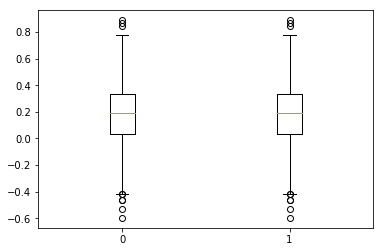

In [8]:
plt.boxplot([[list_sr[i] for i in range(0,len(list_sr),9)], [sharp_list_sr[i] for i in range(0,len(sharp_list_sr),9)]], positions=[0,1])

In [64]:
np.save("multiple_seeds_dataframe",data_new)